### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 8
### Due: Friday, Apr 11th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

# Solution


1. Use the following code snippet to read in SDSS galaxy color data.

<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [2]:
data = np.load('hw_data/hw8_data_1.npy')
# data.shape
print("Column names:", data.dtype.names)

#create arrays
def colors(a,b):
    return data[a] - data[b]
ug = colors('u','g')
gr = colors('g','r')
ri = colors('r','i')
iz = colors('i','z')

z = data['redshift']
spec_class = data['specClass']

print(spec_class)
#count number of galaxies and quasars
galaxy = 0
qso = 0

for i in range(len(data)):
    if data['specClass'][i] == 'GALAXY':
        galaxy += 1

    if data['specClass'][i] == 'QSO':
        qso += 1

print("Number of Galaxies = ", galaxy)
print("Number of Quasars = ", qso)

Column names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')
['QSO' 'GALAXY' 'GALAXY' ... 'QSO' 'QSO' 'QSO']
Number of Galaxies =  42808
Number of Quasars =  7192


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.

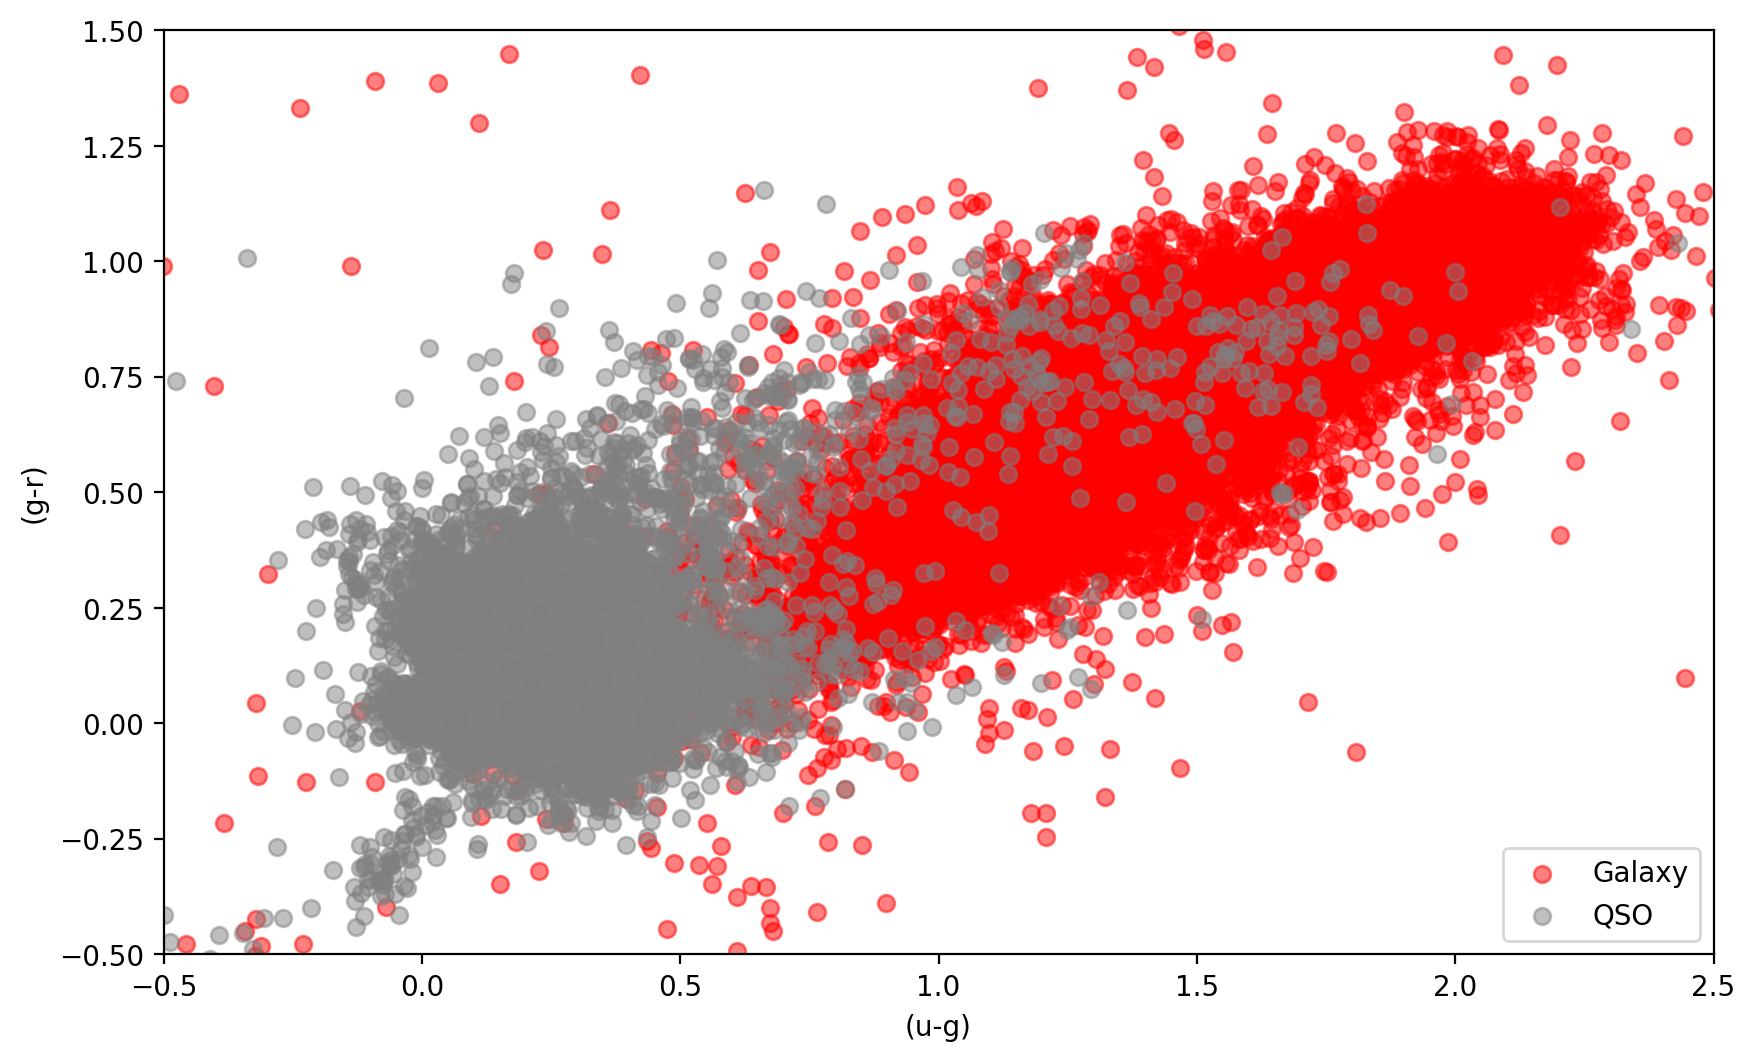

In [3]:
g_mask = spec_class == "GALAXY"
qso_mask = spec_class == "QSO"

plt.figure(figsize=(10, 6))
plt.scatter(ug[g_mask], gr[g_mask], c='red', alpha=0.5,label="Galaxy")
plt.scatter(ug[qso_mask], gr[qso_mask], c='grey', alpha=0.5,label="QSO")

plt.xlabel('(u-g)')
plt.ylabel('(g-r)')

plt.xlim(-0.5,2.5)
plt.ylim(-0.5,1.5)
plt.legend()
plt.show()


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


In [63]:
from  sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve

In [64]:
X = np.zeros((len(ug),5))
X[:,0],X[:,1],X[:,2],X[:,3],X[:,4], = ug,gr,ri,iz,z
y = [0 if cls == 'GALAXY' else 1 for cls in spec_class]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


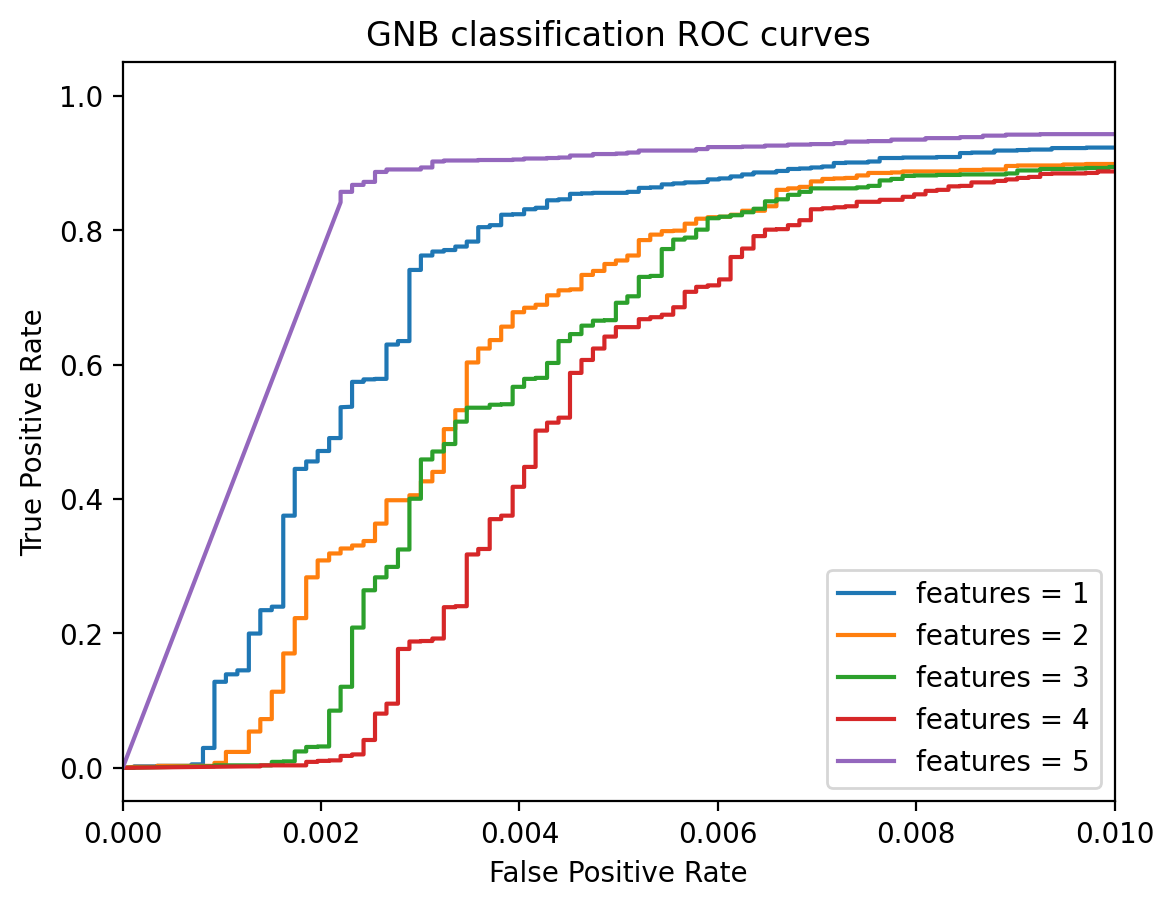

In [65]:
for i in range(1,6):
    clf = GaussianNB()
    clf.fit(X_train[:,:i],y_train)
    predict_prob = clf.predict_proba(X_test[:,:i])
    qso_prob = predict_prob[:,1]
    false, true,_ = roc_curve(y_test,qso_prob)
    plt.plot(false,true,label=f"features = {i}")
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("GNB classification ROC curves")
plt.show()

5. Repeat (4) for Quadratic Discriminant Analysis. 

In [66]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

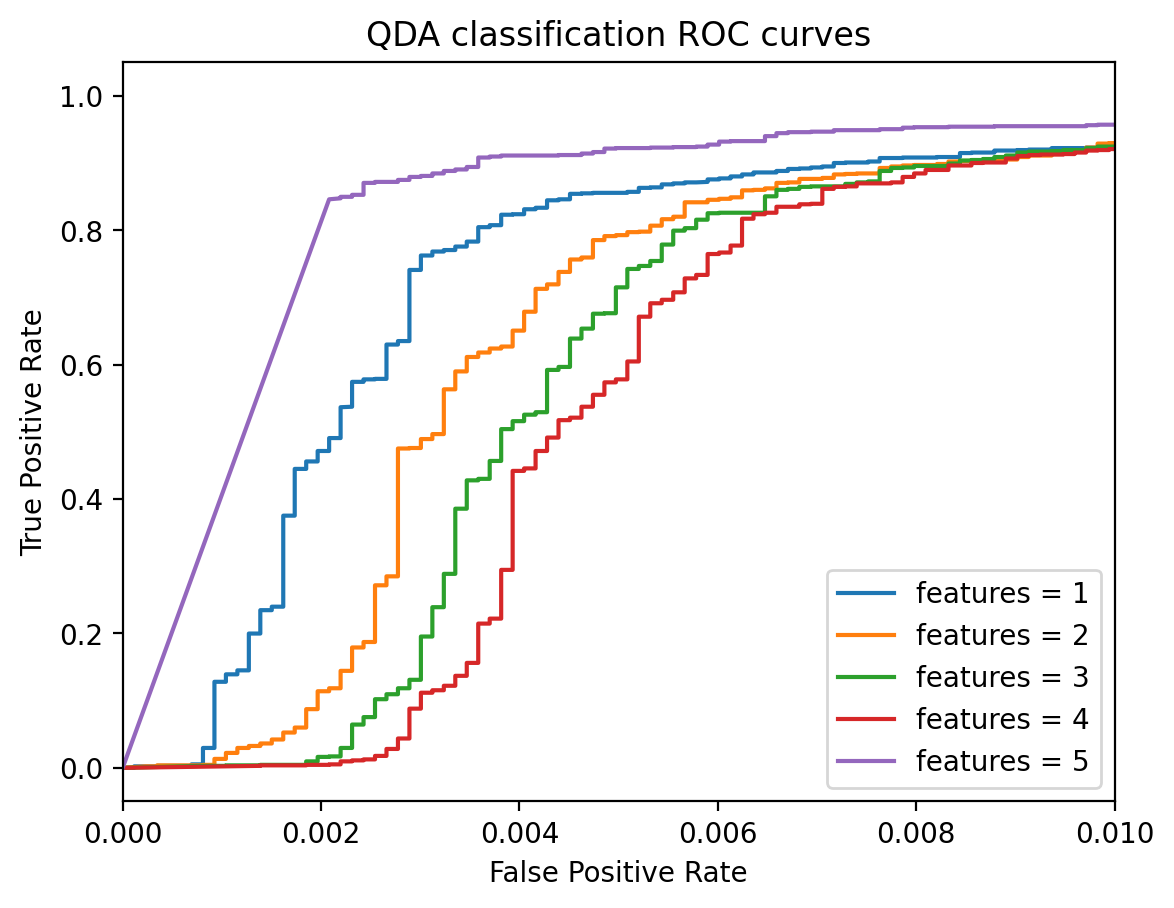

In [67]:
for i in range(1,6):
    clf = QDA()
    clf.fit(X_train[:,:i],y_train)
    predict_prob = clf.predict_proba(X_test[:,:i])
    qso_prob = predict_prob[:,1]
    false, true,_ = roc_curve(y_test,qso_prob)
    plt.plot(false,true,label=f"features = {i}")
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("QDA classification ROC curves")
plt.show()

6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


In [68]:
from astroML.classification import GMMBayes
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

In [69]:
X = np.zeros((len(ug),4))
X[:,0],X[:,1],X[:,2],X[:,3] = ug,gr,ri,iz
y = [0 if cls == 'GALAXY' else 1 for cls in spec_class]

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)

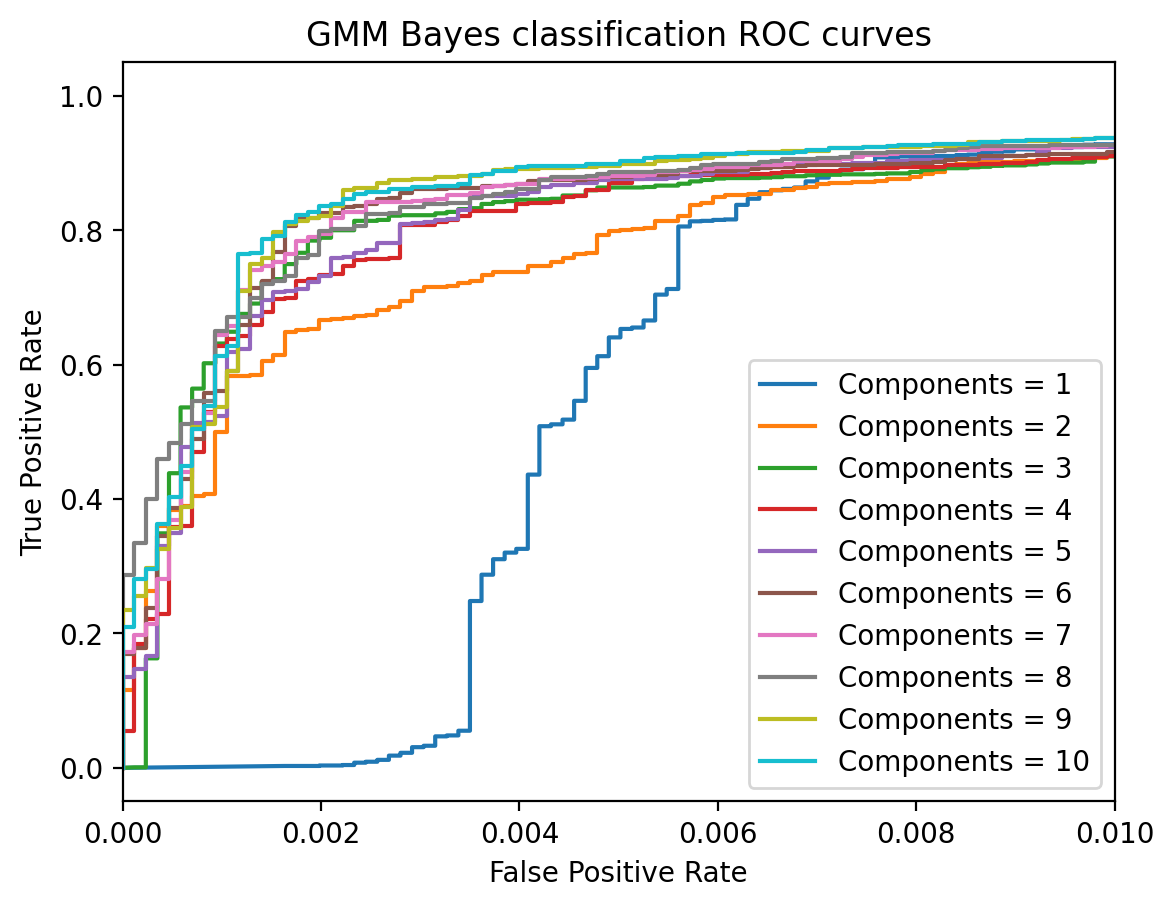

Best Performance with 8 components.


In [70]:
components = np.arange(1,11,1)
accuracy = []
for i in components:
    clf = GMMBayes(n_components=i)
    clf.fit(X_train,y_train)
    predict_prob = clf.predict_proba(X_test)
    qso_prob = predict_prob[:,1]
    false, true,_ = roc_curve(y_test,qso_prob)

    CVpredk = cross_val_predict(clf, X_train, y_train)
    accuracy.append(accuracy_score(y_train, CVpredk))
    
    plt.plot(false,true,label=f"Components = {i}")
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("GMM Bayes classification ROC curves")
plt.show()
print("Best Performance with",components[np.argmax(accuracy)],"components.")

7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

In [71]:
from sklearn.neighbors import KNeighborsClassifier

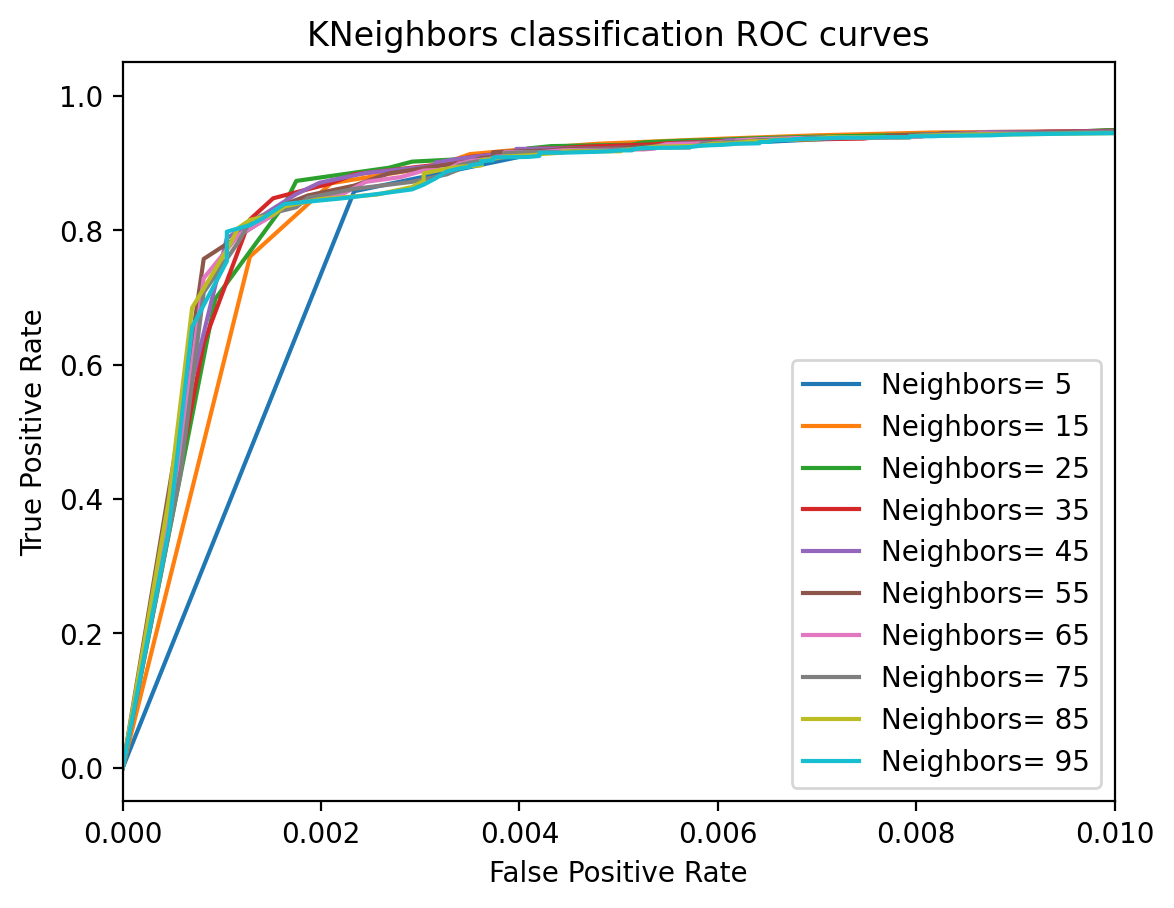

Best Performance with 15 Neighbors.


In [72]:
neighbors = np.arange(5,100,10)
accuracy = []
for i in neighbors:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train,y_train)
    predict_prob = clf.predict_proba(X_test)
    qso_prob = predict_prob[:,1]
    false, true,_ = roc_curve(y_test,qso_prob)

    CVpredk = cross_val_predict(clf, X_train, y_train)
    accuracy.append(accuracy_score(y_train, CVpredk))
 
    plt.plot(false,true,label=f"Neighbors= {i}")
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("KNeighbors classification ROC curves")
plt.show()
print("Best Performance with",neighbors[np.argmax(accuracy)],"Neighbors.")

8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 

In [73]:
from sklearn.tree import DecisionTreeClassifier

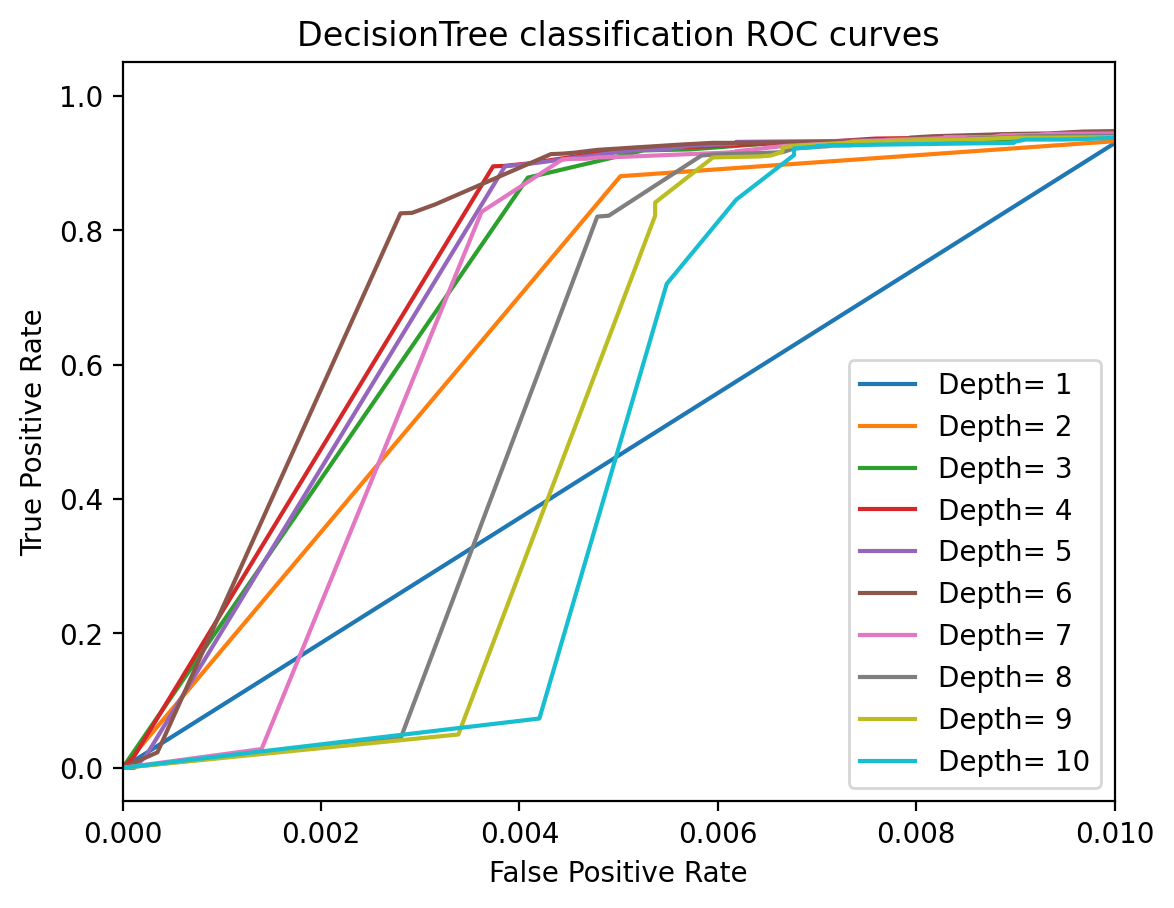

Best Performance with 6 depth.


In [74]:
depth = np.arange(1,11,1)
accuracy = []
for i in depth:
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train,y_train)
    predict_prob = clf.predict_proba(X_test)
    qso_prob = predict_prob[:,1]
    false, true,_ = roc_curve(y_test,qso_prob)

    CVpredk = cross_val_predict(clf, X_train, y_train)
    accuracy.append(accuracy_score(y_train, CVpredk))
 
    plt.plot(false,true,label=f"Depth= {i}")
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("DecisionTree classification ROC curves")
plt.show()
print("Best Performance with",depth[np.argmax(accuracy)],"depth.")

9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 

Best Classifier: KNeighborsClassifier(n_neighbors=15)


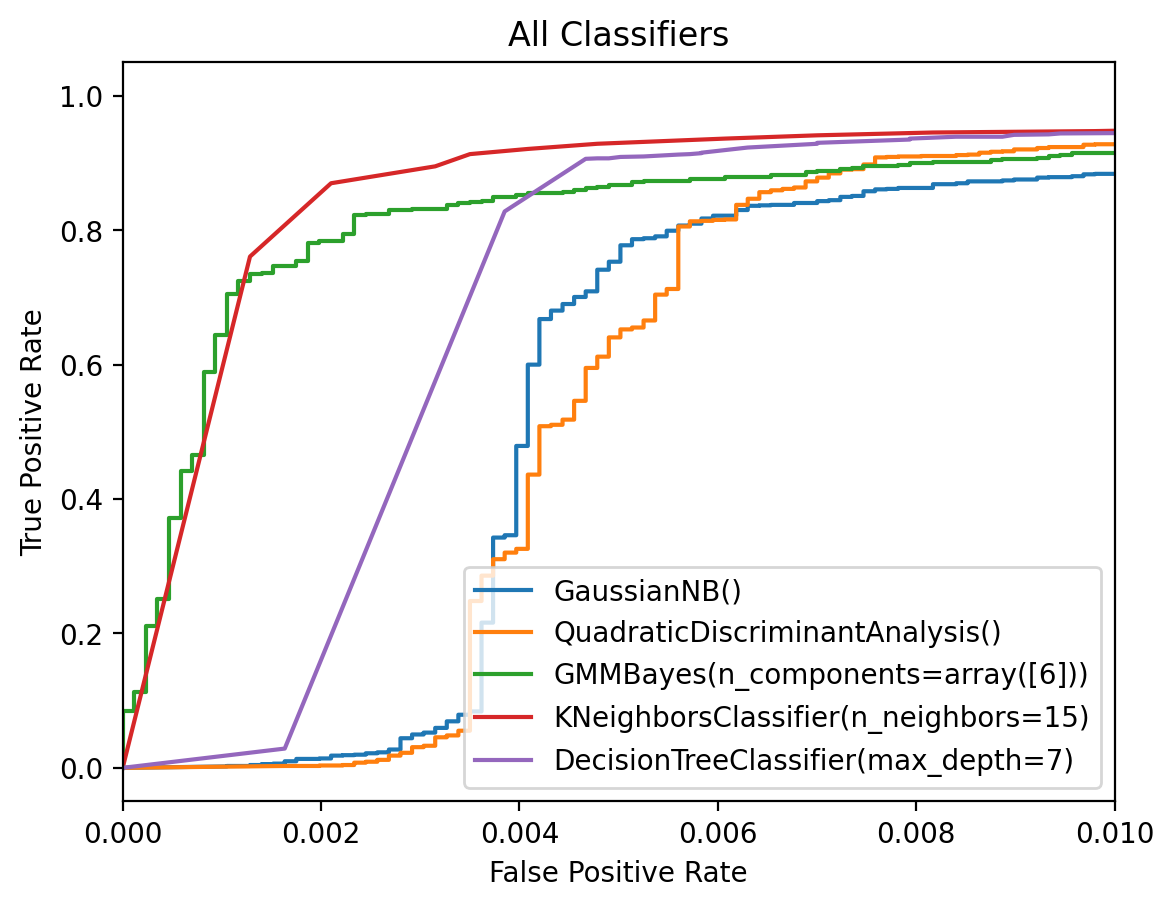

In [75]:
classifier = [GaussianNB(), QDA(), GMMBayes(n_components=6), KNeighborsClassifier(n_neighbors=15), DecisionTreeClassifier(max_depth=7)]

accuracy = []
for i in classifier:
    clf = i
    clf.fit(X_train,y_train)
    predict_prob = clf.predict_proba(X_test)
    qso_prob = predict_prob[:,1]
    false, true,_ = roc_curve(y_test,qso_prob)

    CVpredk = cross_val_predict(clf, X_train, y_train)
    accuracy.append(accuracy_score(y_train, CVpredk))
 
    plt.plot(false,true,label=f"{i}")
    plt.xlim(0,0.01)
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("All Classifiers")

print("Best Classifier:",classifier[np.argmax(accuracy)])

10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier.

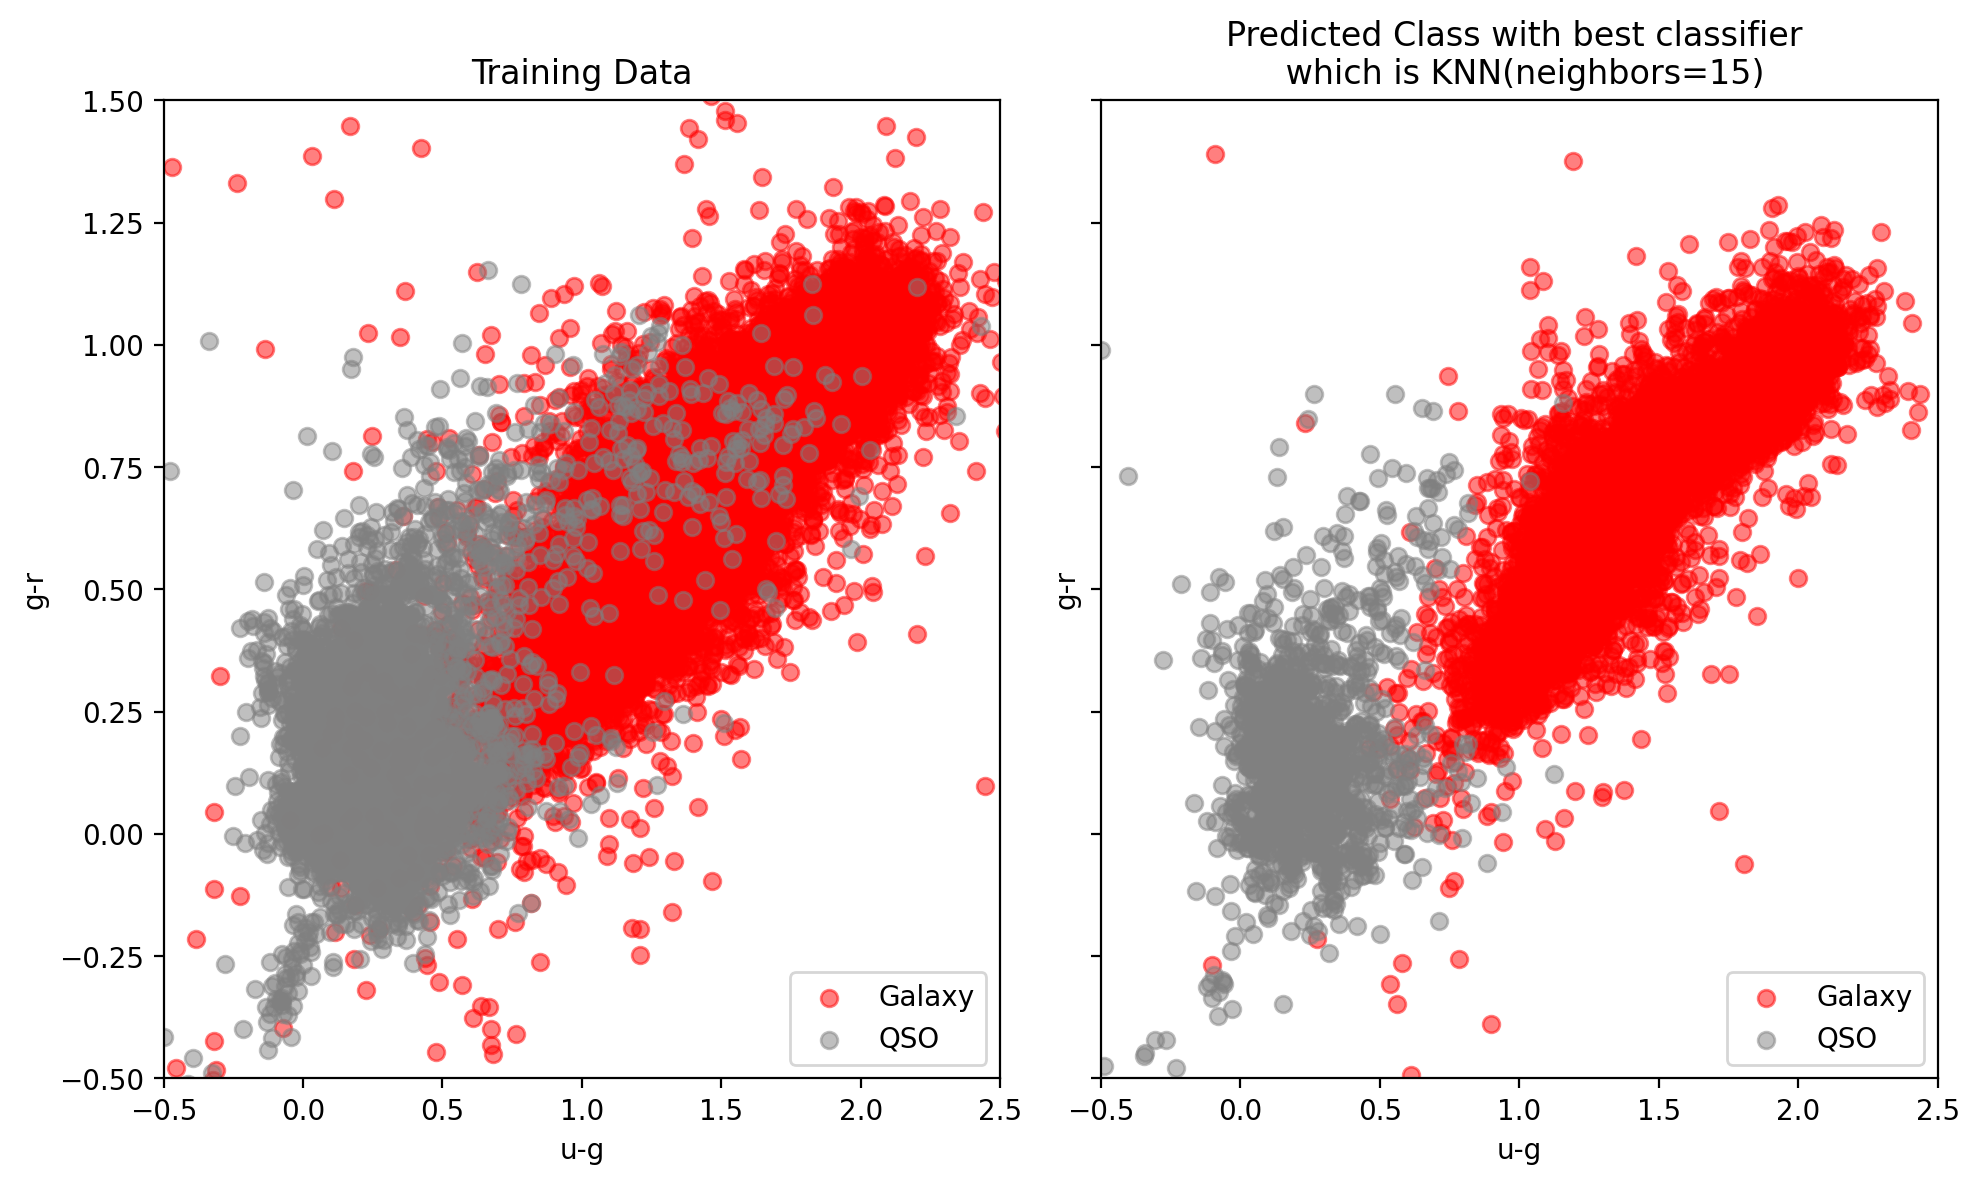

In [95]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)


y_train = np.array(y_train)
ax[0].scatter(X_train[y_train==0][:, 0], X_train[y_train==0][:, 1], alpha=0.5,label="Galaxy",c='red')
ax[0].scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], alpha=0.5,label="QSO",c='grey')
ax[0].set_xlabel('u-g')
ax[0].set_ylabel('g-r')
ax[0].set_xlim(-0.5, 2.5)
ax[0].set_ylim(-0.5, 1.5)
ax[0].set_title("Training Data")
ax[0].legend()

clf = KNeighborsClassifier(n_neighbors=15)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

ax[1].scatter(X_test[y_pred==0][:, 0], X_test[y_pred==0][:, 1], alpha=0.5,label="Galaxy",c='red')
ax[1].scatter(X_test[y_pred==1][:, 0], X_test[y_pred==1][:, 1], alpha=0.5,label="QSO",c='grey')
ax[1].set_xlabel('u-g')
ax[1].set_ylabel('g-r')
ax[1].set_xlim(-0.5, 2.5)
ax[1].set_ylim(-0.5, 1.5)
ax[1].set_title("Predicted Class with best classifier \n which is KNN(neighbors=15)")
ax[1].legend()


plt.tight_layout()
plt.show()